# Introdution 
The problem is to find a way to predict how much time some orders will take after receiving some kind of parameters, for example, the latitude and longitude of the store and the shopper(Who will do the purchase at the store), and also we have some more parameters. This is a problem of Cornershop and a good challenge to be solved. I used google colab and the python language to solve this problem. 

OBS.: If you want to be run only what you need to generate the model I include the (Run) on the inside of the title. 

# Import data (Run)

The first step is to upload the data and start the EDA to do the right choices

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cornershop').getOrCreate()

The spark can be used when we need to create some changes in dataFrame. When I finish I verify that don't need to use spark because the data is not so big. 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score

order_product = pd.read_csv("/content/drive/MyDrive/Cornershoper/data/order_products.csv")
orders = pd.read_csv("/content/drive/MyDrive/Cornershoper/data/orders.csv")
shoppers = pd.read_csv("/content/drive/MyDrive/Cornershoper/data/shoppers.csv")
store = pd.read_csv("/content/drive/MyDrive/Cornershoper/data/storebranch.csv")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Obs.: We will first take a look at each data and see what features we can use into our model, then we see how we could join these data to use together, so we already know that we need to have the order_id and product_id will be one of our keys to join the data.

I decide to use and abuse text to explain each step. So you don't see many functions here. 

# EDA order_product

Now let's take a look inside each dataset and do some notes. 
The first is the order_product:
- order_id: ID of the order
- product_id: ID of the product
- quantity: The quantity ordered of this product
- buy_unit: The unit of the product (KG/UN)



In [4]:
order_product.info() #the idea of use info is to see the types of each feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198500 entries, 0 to 198499
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   order_id    198500 non-null  object 
 1   product_id  198500 non-null  object 
 2   quantity    198500 non-null  float64
 3   buy_unit    198500 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.1+ MB


In [5]:
order_product.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


Do we have some NaN values?

In [6]:
order_product.isnull().sum()

order_id      0
product_id    0
quantity      0
buy_unit      0
dtype: int64

Any NaN values, so we don't need to think about this by now! 

This dataset for example has only as a float value the quantity, so we know that this is us **Quantitative variable** and buy_unit is **Qualitative variable**, the order and product id will be us key for joins, so let's take a look at the quantity describe! 

In [7]:
order_product.describe() #The idea here we can see some statistic things for the quantitative variables

,quantity
count,198500.000000
mean,1.824126
std,1.905529
min,0.055000
25%,1.000000
50%,1.000000
75%,2.000000
max,100.000000


In [8]:
order_product['buy_unit'].unique() #Here we just confirme that we have only UN and KG in buy_unit

array(['UN', 'KG'], dtype=object)

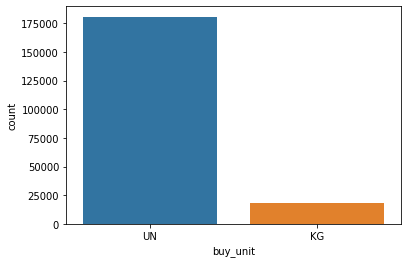

In [9]:
sns.countplot(x='buy_unit', data=order_product);


In [10]:
print("Units that are in UN: ",order_product[order_product['buy_unit']=='UN']['order_id'].count())
print("Units that are in KG: ",order_product[order_product['buy_unit']=='KG']['order_id'].count())

Units that are in UN:  180654
Units that are in KG:  17846


After seeing these pieces of information we can have some problems to solve, for example, see how we could unify these metrics KG in Un or only do separates analyses here, but the main objective here is to predict how many times the order needs to finish, so when we think that one person needs more time to measurement the pounds of something it could be included as a plus in us model. But and the end of the model I realize that don't need to separate these things, the time shouldn't increase too much. 

# EDA orders

Orders:
- order_id: ID of the order
- lat: The latitude of the delivery location
- lng: The longitude of the delivery location
- promised_time: The delivery time promised to the user
- on_demand: If true, the order was promised to be delivered in less than X minutes
- shopper_id: ID representing the shopper completed the order.
- store_branch_id: ID of the store branch
- total_minutes: The total minutes it took to complete the order (label)


In [11]:
orders.info() #the idea of use info is to see the types of each feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         10000 non-null  object 
 1   lat              10000 non-null  float64
 2   lng              10000 non-null  float64
 3   promised_time    10000 non-null  object 
 4   on_demand        10000 non-null  bool   
 5   shopper_id       10000 non-null  object 
 6   store_branch_id  10000 non-null  object 
 7   total_minutes    8000 non-null   float64
dtypes: bool(1), float64(3), object(4)
memory usage: 556.8+ KB


In [12]:
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


Do we have some missing values? 

In [13]:
orders.isnull().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      2000
dtype: int64

We have 2000 total_minutes as NaN, so we can work without these, and then use these data that don't have the total_minutes as the submission file.

Now, let's take a look at the correlation between variables.

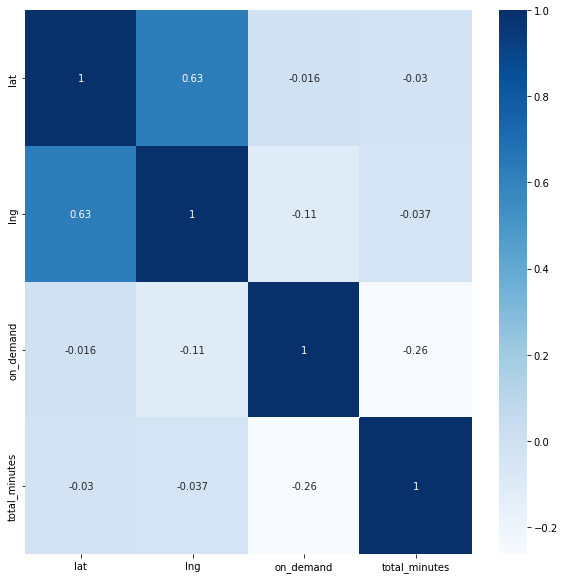

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(orders.corr(),cbar=True,annot=True,cmap='Blues')


It's clear that we have a high correlation between lat and lng, but total_minutes us variable X we don't see any correlation, maybe after we calculate the distance, we could find a correlation in time, but by now we can't see anything. 

In [15]:
orders.describe()

,lat,lng,total_minutes
count,10000.000000,10000.000000,8000.000000
mean,-33.427090,-70.668017,81.106130
std,0.558675,0.400249,34.720837
min,-36.942135,-73.144281,11.969489
25%,-33.426861,-70.605795,55.225480
50%,-33.398110,-70.574591,74.731672
75%,-33.353783,-70.540307,100.273498
max,-29.833517,-70.453728,304.190303


Some good points: 

*   We have 5 variables where lat, lng, and total_minutes are **Quantitative variable** and promised_time and on_demand are **Qualitative variable**
*   By the way we need to be careful with these qualitative, because exist a good opportunity to include these pieces of information inside the model, we don't have sure yet but could be good. But we need to pre-process the variables. 






TODO: Create a new column with the name distance that will be generated using geopy, we need to use the store to know the start and the endpoints, we could use the google API for calculates distance this more powerfully, but today we will use the geopy that also have good.

# EDA shoppers

shoppers:
- shopper_id: ID of the shopper
- seniority: The experience level of the shopper.
- found_rate: Percentage of products found by shopper historical.
- picking_speed: Historical picking speed, products pr minutes.
- accepted_rate: Percentage of orders historically accepted by shopper
- rating: client rating of shopper

In [16]:
shoppers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   shopper_id     2864 non-null   object 
 1   seniority      2864 non-null   object 
 2   found_rate     2763 non-null   float64
 3   picking_speed  2864 non-null   float64
 4   accepted_rate  2837 non-null   float64
 5   rating         2780 non-null   float64
dtypes: float64(4), object(2)
memory usage: 134.4+ KB


In [17]:
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [18]:
shoppers.isnull().sum()

shopper_id         0
seniority          0
found_rate       101
picking_speed      0
accepted_rate     27
rating            84
dtype: int64

Here we have more NaN values, so we need to work on solving this problem! 

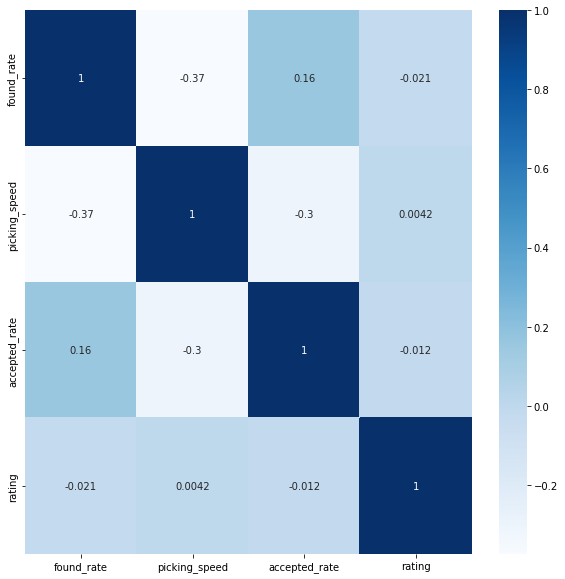

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(shoppers.corr(),cbar=True,annot=True,cmap='Blues')


In [20]:
shoppers.describe()

,found_rate,picking_speed,accepted_rate,rating
count,2763.000000,2864.000000,2837.000000,2780.000000
mean,0.861082,1.762392,0.908276,4.848428
std,0.031038,0.665962,0.107911,0.133011
min,0.737300,0.650000,0.240000,3.880000
25%,0.842900,1.290000,0.880000,4.800000
50%,0.863900,1.580000,0.944444,4.880000
75%,0.881950,2.120000,1.000000,4.960000
max,0.971000,7.040000,1.000000,5.000000



After this EDA I verify that we can use the seniority as a dummy, and this can bring more power to the model. 

# EDA store

store:
- store_branch_id: ID of the store branch
- store: ID representing the store
- lat: Latitude of the branch location
- lng: Longitude of the branch location

In [21]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store_branch_id  476 non-null    object 
 1   store_id         476 non-null    object 
 2   lat              476 non-null    float64
 3   lng              476 non-null    float64
dtypes: float64(2), object(2)
memory usage: 15.0+ KB


In [22]:
store.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [23]:
store.describe()

,lat,lng
count,476.000000,476.000000
mean,-33.457661,-70.737432
std,0.762492,0.513308
min,-36.904347,-73.096660
25%,-33.431260,-70.611515
50%,-33.401876,-70.577312
75%,-33.359701,-70.544190
max,-29.901425,-70.492256


In [24]:
store.isnull().sum()

store_branch_id    0
store_id           0
lat                0
lng                0
dtype: int64

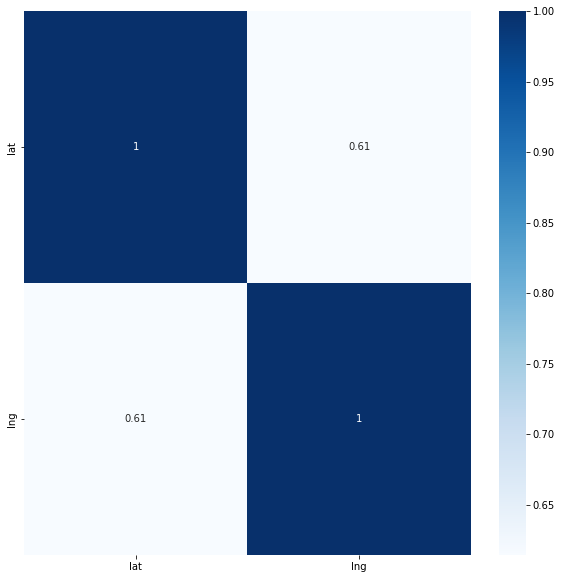

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(store.corr(),cbar=True,annot=True,cmap='Blues')


This data have the idea to get the distance between the orders and the store

# Next Steps


*   After seeing the EDA we know that we have two things to solve problems with NA values
*   We already know that need calculate the distance between the store and the order because this feature is important to predict the total_minutes
*   We need to join the tables to generate only one dataFrame to include in the model
*   We can run the OLS as the first set and see the test to know how better was
*   We can take a look into the multi-level to see how great this can be and see the results to compare.
*   We can use the XGBoost to see if it's better than the others models. 
*   We can use a PCA to reduce the number of features if need, but probably not! 



# Data Transform (Run)

We have a lot of ways to work with, and we can test each one, but today I will only dropNa as the first model and the second model I will use statistics to fill the NaN values, the Idea is to use clustering to know each cluster the NaN can be included and then add the mean of the group into the missing values. 

In [26]:
dfOrdersDropNa = orders.dropna()

In [27]:
dfOrdersDropNa.isnull().sum()

order_id           0
lat                0
lng                0
promised_time      0
on_demand          0
shopper_id         0
store_branch_id    0
total_minutes      0
dtype: int64

I decide to use the dropna in the shoppers, only because after running the model I see that when I use fillna to use the mean the result of log-likelihood isn't better than when I dropna. 

In [28]:
dfShoppersDropNa = shoppers.dropna()

In [29]:
dfShoppersDropNa.isnull().sum()

shopper_id       0
seniority        0
found_rate       0
picking_speed    0
accepted_rate    0
rating           0
dtype: int64

In [30]:
order_product.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [31]:
somaQuantity = order_product.groupby(['order_id'])['quantity'].sum()

In [32]:
order_product_sum=somaQuantity.to_frame()

In [33]:
order_product_sum.head()

,quantity
order_id,
0004a3841c1eeb6c6e77585a941c21e0,8.000
0005a6ecbbde1e8d273f5577bcff2c9c,2.000
0007baeb6700fc203be2d1f1e11222d7,39.000
0012195a6a8ca9ec308a3010eeea8ebc,13.000
0013011fa72b498b9feb84f4e7104980,64.636


In [34]:
order_product_sum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9978 entries, 0004a3841c1eeb6c6e77585a941c21e0 to ffe8fa40d7e51f9860b62b5e9d798a57
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   quantity  9978 non-null   float64
dtypes: float64(1)
memory usage: 155.9+ KB


# Join tables (Run)

This step was a good candidate to use spark, but let's keep with the pandas, just because the data isn't big enough. The main idea here is to generate a unique data frame to be used inside the models.

In [35]:
storeRenamed = store.rename(columns={"lat":"lat_store", "lng":"lng_store"},inplace= False)

In [36]:
storeRenamed.head()

,store_branch_id,store_id,lat_store,lng_store
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [37]:
dfOrdersWithOrderProduct = pd.merge(dfOrdersDropNa,order_product_sum,'inner',"order_id")
dfOrdersWithOrderProductWithShopper = pd.merge(dfOrdersWithOrderProduct,dfShoppersDropNa,'inner',"shopper_id")
dataModel = pd.merge(dfOrdersWithOrderProductWithShopper,storeRenamed,'inner',"store_branch_id")


In [38]:
dataModel.drop({"order_id", "shopper_id","store_branch_id","store_id","promised_time"},axis='columns',inplace=True)

Now, let's implement the functions that calculate the distance between the coordinators. 

In [39]:
def geoDist (dataModel):
  import geopy.distance

  coords_1 = (dataModel['lat'], dataModel['lng'])
  coords_2 = (dataModel['lat_store'], dataModel['lng_store'])

  return geopy.distance.vincenty(coords_1, coords_2).km

In [40]:
dataModel['distance']=dataModel.apply(geoDist, axis=1)

In [41]:
dataModel.head()

,lat,lng,on_demand,total_minutes,quantity,seniority,found_rate,picking_speed,accepted_rate,rating,lat_store,lng_store,distance
0,-33.501675,-70.579369,True,67.684264,18.756,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,-33.48528,-70.57925,1.818407
1,-33.491167,-70.571649,True,160.336211,65.900,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,-33.48528,-70.57925,0.961885
2,-33.493406,-70.594164,False,122.239210,156.000,6c90661e6d2c7579f5ce337c3391dbb9,0.8909,1.17,0.96,5.00,-33.48528,-70.57925,1.653246
3,-33.487836,-70.572412,False,133.113926,122.646,6c90661e6d2c7579f5ce337c3391dbb9,0.8462,1.11,0.96,4.96,-33.48528,-70.57925,0.695847
4,-33.504759,-70.552168,False,94.734479,99.216,50e13ee63f086c2fe84229348bc91b5b,0.8138,1.89,0.84,4.68,-33.48528,-70.57925,3.316783


I think that could be good to remove the lat and lng, but when I test the model I realize that the lat, lng, and distance together it's good!



In [42]:
#dataModel.drop({'lat','lng','lat_store','lng_store'},axis='columns',inplace=True)

In [43]:
dataModel.head()

,lat,lng,on_demand,total_minutes,quantity,seniority,found_rate,picking_speed,accepted_rate,rating,lat_store,lng_store,distance
0,-33.501675,-70.579369,True,67.684264,18.756,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,-33.48528,-70.57925,1.818407
1,-33.491167,-70.571649,True,160.336211,65.900,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,-33.48528,-70.57925,0.961885
2,-33.493406,-70.594164,False,122.239210,156.000,6c90661e6d2c7579f5ce337c3391dbb9,0.8909,1.17,0.96,5.00,-33.48528,-70.57925,1.653246
3,-33.487836,-70.572412,False,133.113926,122.646,6c90661e6d2c7579f5ce337c3391dbb9,0.8462,1.11,0.96,4.96,-33.48528,-70.57925,0.695847
4,-33.504759,-70.552168,False,94.734479,99.216,50e13ee63f086c2fe84229348bc91b5b,0.8138,1.89,0.84,4.68,-33.48528,-70.57925,3.316783



Now let's convert the seniority into dummies variables. In the Validation of the model, we will see that this is very good for the model. 

In [44]:
dataModelOLS = pd.get_dummies(dataModel)

In [45]:
dataModelOLS.head()

,lat,lng,on_demand,total_minutes,quantity,found_rate,picking_speed,accepted_rate,rating,lat_store,lng_store,distance,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f
0,-33.501675,-70.579369,True,67.684264,18.756,0.9024,1.30,0.92,4.76,-33.48528,-70.57925,1.818407,0,0,1,0
1,-33.491167,-70.571649,True,160.336211,65.900,0.9024,1.30,0.92,4.76,-33.48528,-70.57925,0.961885,0,0,1,0
2,-33.493406,-70.594164,False,122.239210,156.000,0.8909,1.17,0.96,5.00,-33.48528,-70.57925,1.653246,0,0,1,0
3,-33.487836,-70.572412,False,133.113926,122.646,0.8462,1.11,0.96,4.96,-33.48528,-70.57925,0.695847,0,0,1,0
4,-33.504759,-70.552168,False,94.734479,99.216,0.8138,1.89,0.84,4.68,-33.48528,-70.57925,3.316783,0,1,0,0


Let's take a look at the correlation between variables. We probably don't remove any variable only because doesn't correlate, but it's can be tested the model without someone who likes these. 

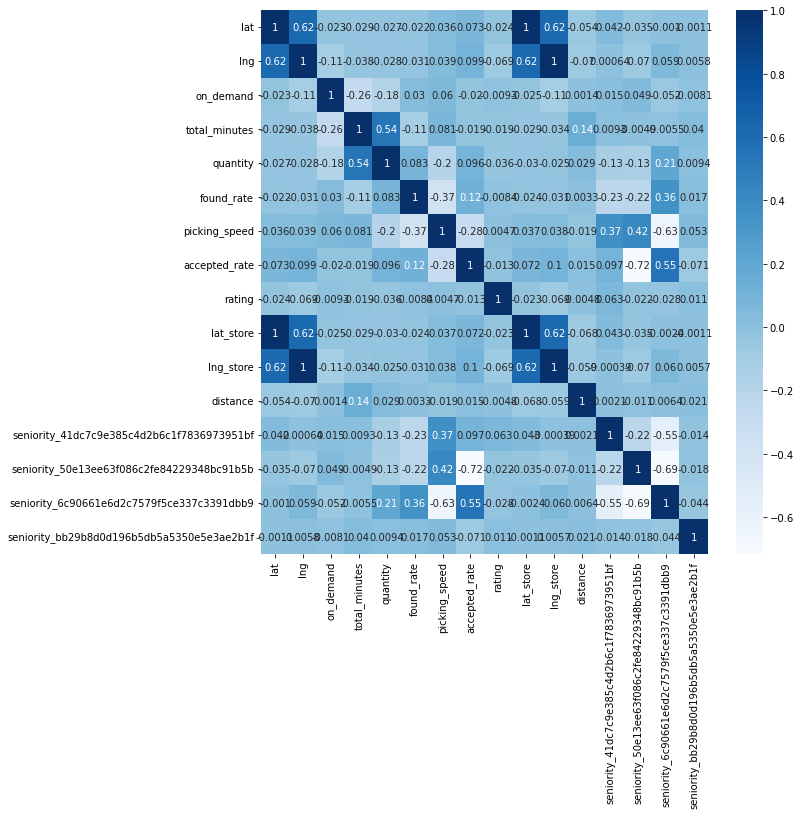

In [46]:
plt.figure(figsize=(10,10))
sns.heatmap(dataModelOLS.corr(),cbar=True,annot=True,cmap='Blues')

# Start Machine Learning algorithms
The main idea here is to find the best model having the best fit. And then Use this model to predict the orders that don't have the total_minutes. 

# OLS

First, let's use the Regression as always shown be the start.
And let's analyze the log-likelihood, is important to know how great it's better is the model. And also look at the R-squared and adj, because this shows to us one idea of the error. But the most important is the Log-Likelihood 

In [47]:
modelOLS = smf.ols(formula='total_minutes ~ on_demand+lat+lng+lat_store+lng_store+	quantity	+ found_rate +	picking_speed +	accepted_rate+ 	rating+	distance+	seniority_41dc7c9e385c4d2b6c1f7836973951bf+	seniority_50e13ee63f086c2fe84229348bc91b5b+	seniority_6c90661e6d2c7579f5ce337c3391dbb9', data=dataModelOLS).fit()
print(modelOLS.params)
print(modelOLS.summary())

Intercept                                     -63.695504
on_demand[T.True]                             -11.902248
lat                                           -73.638925
lng                                           -17.846771
lat_store                                      74.795997
lng_store                                      13.855924
quantity                                        0.547308
found_rate                                   -106.465054
picking_speed                                  10.425580
accepted_rate                                 -19.426712
rating                                         -1.918723
distance                                        2.748225
seniority_41dc7c9e385c4d2b6c1f7836973951bf    -19.782712
seniority_50e13ee63f086c2fe84229348bc91b5b    -23.318763
seniority_6c90661e6d2c7579f5ce337c3391dbb9    -17.677649
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          total_minutes   R-squared: 

In [48]:
yOLS = dataModelOLS['total_minutes']
XOLS = dataModelOLS.drop(['total_minutes'], axis=1)

cols = list(dataModelOLS.columns.values) 
cols.pop(cols.index('total_minutes'))
train_XOLS, test_XOLS, train_yOLS, test_yOLS = train_test_split(XOLS.values, yOLS.values, test_size=0.15)
test_XOLS= pd.DataFrame(test_XOLS,columns=cols)
test_XOLS= test_XOLS.convert_dtypes()
test_XOLS['on_demand']=test_XOLS['on_demand'].astype('bool')
test_XOLS['seniority_41dc7c9e385c4d2b6c1f7836973951bf']=test_XOLS['seniority_41dc7c9e385c4d2b6c1f7836973951bf'].astype('uint8')
test_XOLS['seniority_50e13ee63f086c2fe84229348bc91b5b']=test_XOLS['seniority_50e13ee63f086c2fe84229348bc91b5b'].astype('uint8')
test_XOLS['seniority_6c90661e6d2c7579f5ce337c3391dbb9']=test_XOLS['seniority_6c90661e6d2c7579f5ce337c3391dbb9'].astype('uint8')
test_XOLS['seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f']=test_XOLS['seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f'].astype('uint8')

predictOLS = modelOLS.predict(test_XOLS)
print("Mean absolute error OLS level: {:.2f}".format(mean_absolute_error(predictOLS,test_yOLS)))


Mean absolute error OLS level: 20.05


# GLMM (Run)

Now, let's use the multi-level model, and use the seniority as the groups.


In [49]:
modelMult1 = smf.mixedlm(formula='total_minutes ~ on_demand+lat+lng+lat_store+lng_store+	quantity	+ found_rate +	picking_speed +	accepted_rate+ 	rating+	distance+	seniority_41dc7c9e385c4d2b6c1f7836973951bf+	seniority_50e13ee63f086c2fe84229348bc91b5b+	seniority_6c90661e6d2c7579f5ce337c3391dbb9', data=dataModelOLS, groups=dataModel["seniority"]).fit()
print(modelMult1.params)
print(modelMult1.summary())

Intercept                                     -63.695504
on_demand[T.True]                             -11.902248
lat                                           -73.638925
lng                                           -17.846771
lat_store                                      74.795997
lng_store                                      13.855924
quantity                                        0.547308
found_rate                                   -106.465054
picking_speed                                  10.425580
accepted_rate                                 -19.426712
rating                                         -1.918723
distance                                        2.748225
seniority_41dc7c9e385c4d2b6c1f7836973951bf    -19.782712
seniority_50e13ee63f086c2fe84229348bc91b5b    -23.318763
seniority_6c90661e6d2c7579f5ce337c3391dbb9    -17.677649
Group Var                                       1.000000
dtype: float64
                             Mixed Linear Model Regression Results
Model:

In [50]:
yMulti = dataModelOLS['total_minutes']
XMulti = dataModelOLS.drop(['total_minutes'], axis=1)

cols = list(dataModelOLS.columns.values) 
cols.pop(cols.index('total_minutes'))
train_XMulti, test_XMulti, train_yMulti, test_yMulti = train_test_split(XMulti.values, yMulti.values, test_size=0.15)
test_XMulti= pd.DataFrame(test_XMulti,columns=cols)
test_XMulti= test_XMulti.convert_dtypes()
test_XMulti['on_demand']=test_XMulti['on_demand'].astype('bool')
test_XMulti['seniority_41dc7c9e385c4d2b6c1f7836973951bf']=test_XMulti['seniority_41dc7c9e385c4d2b6c1f7836973951bf'].astype('uint8')
test_XMulti['seniority_50e13ee63f086c2fe84229348bc91b5b']=test_XMulti['seniority_50e13ee63f086c2fe84229348bc91b5b'].astype('uint8')
test_XMulti['seniority_6c90661e6d2c7579f5ce337c3391dbb9']=test_XMulti['seniority_6c90661e6d2c7579f5ce337c3391dbb9'].astype('uint8')
test_XMulti['seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f']=test_XMulti['seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f'].astype('uint8')

predictMulti = modelMult1.predict(test_XMulti)
print("Mean absolute error multi level: {:.2f}".format(mean_absolute_error(predictMulti,test_yMulti)))


Mean absolute error multi level: 19.84


See, the multi-level was the best by now, having the high Log-Likelihood and also having the best absolute error.
Obs.: We just calculated the mean absolute error to compare with the next model (XGBoost), only because we don't have how to calculate the log-likelihood of this model, but we can calculate the score and mean absolute, so to compare we will use mean absolute.

# XGBoost (Run)

In [51]:
y = dataModelOLS['total_minutes']
X = dataModelOLS.drop(['total_minutes'], axis=1).select_dtypes(exclude=['object'])
 
train_X, test_X, train_y, test_y = train_test_split(X.values, y.values, test_size=0.15)
 
modelXG = XGBRegressor()
 
modelXG.fit(train_X, train_y, verbose=False)
 
predictionsXG = modelXG.predict(test_X)

print("Score for XGBosst: {:.2f}" .format(modelXG.score(test_X, test_y)))
print("Mean absolute error XGBoost: {:.2f}".format(mean_absolute_error(predictionsXG, test_y)))

[19:24:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score for XGBosst: 0.53
Mean absolute error XGBoost: 18.22


See, we have the low mean absolute error with the XGBoost, and pay attention that I don't increase the parameters to have a better model. I can do this and make this model with the best fit. 

In [52]:
lm = linear_model.LinearRegression()
modelRegression = lm.fit(train_X, train_y)
predictionsRegression = lm.predict(test_X)
print("Score for Regression: {:.2f}" .format(modelRegression.score(test_X, test_y)))
print("Mean absolute error Regression: {:.2f}".format(mean_absolute_error(predictionsRegression, test_y)))


Score for Regression: 0.41
Mean absolute error Regression: 20.61


Just to compare with the sklearn linear regression, we have the best error than the OLS and Multi-Level, but not better than XGBoost.


# Predict Model (Run)

Now let's organize the data to use the orders that don't have the total_minutes. We only are using in the submission file the values that have all parameters that need to predict. 

In [53]:
orders['total_minutes'] = orders['total_minutes'].replace(np.nan, 0)
orders_predict =orders[orders['total_minutes']==0]
dfOrdersWithOrderProductPredict = pd.merge(orders_predict,order_product_sum,'left',"order_id")
dfOrdersWithOrderProductWithShopperPredict = pd.merge(dfOrdersWithOrderProductPredict,shoppers,'inner',"shopper_id")
dataModelPredict = pd.merge(dfOrdersWithOrderProductWithShopperPredict,storeRenamed,'inner',"store_branch_id")
dataModelPredict.drop({"shopper_id","store_branch_id","store_id","promised_time"},axis='columns',inplace=True)
dataModelPredict['distance']=dataModelPredict.apply(geoDist, axis=1)
dataModelPredict.set_index('order_id', inplace=True)
dataModelPredictDummies = pd.get_dummies(dataModelPredict)


In [54]:
y_predict = dataModelPredictDummies.drop('total_minutes',axis='columns',inplace=False)

In [55]:
modelMult1.predict(y_predict)

order_id
3a226ea48debc0a7ae9950d5540f2f34     77.242124
57f8d47123cd74908630c42e6a1abfb9     79.633697
bc9909874db80c80591f88743a76587d    116.677478
a8f07136d11ff8d9e8452cb64397656d     69.724644
ab1433010e450de12baae458a11cf764    192.316354
                                       ...    
5b7a7e77630db080e35d2d6e4d04b373     65.139817
038ebf3f7fb4fe8c88769468d6cf4778           NaN
3d8cc5b44a07130eeacc02e139f5e1a6     56.226773
2ed4b645df9ab97ccf13c38264f31519     81.704070
fa77da3cb82b5245e95eaa15e2b640f2     75.183257
Length: 2000, dtype: float64

In [56]:
dataModelPredict['total_minutes']= modelMult1.predict(y_predict)
dataModelPredict.to_csv('submissionFile.csv')

In [57]:
y_predictClean = y_predict.reset_index()

In [58]:
y_predictClean.drop('order_id', axis='columns', inplace=True)

In [59]:
y_predictClean

,lat,lng,on_demand,quantity,found_rate,picking_speed,accepted_rate,rating,lat_store,lng_store,distance,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f
0,-32.987022,-71.544842,True,18.000,0.8313,2.57,0.76,4.92,-33.008213,-71.545615,2.351240,0,1,0,0
1,-32.978695,-71.537517,True,42.000,0.8460,1.23,0.92,4.80,-33.008213,-71.545615,3.360024,0,0,1,0
2,-33.017965,-71.551822,False,90.800,0.8365,1.37,1.00,4.68,-33.008213,-71.545615,1.227264,0,0,1,0
3,-32.984657,-71.542678,True,39.180,0.8656,1.14,0.84,4.68,-33.008213,-71.545615,2.626798,0,1,0,0
4,-32.984762,-71.542657,False,237.999,0.8861,1.34,1.00,4.96,-33.008213,-71.545615,2.615429,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-33.329951,-70.529046,False,12.200,0.8568,1.30,1.00,4.76,-33.340888,-70.521378,1.407453,0,0,1,0
1996,-33.372346,-70.506877,True,NaN,0.8794,1.49,0.96,4.96,-33.376372,-70.525559,1.794935,1,0,0,0
1997,-33.406006,-70.578381,True,3.000,0.8493,1.57,0.60,4.76,-33.413616,-70.558354,2.045149,0,1,0,0
1998,-33.435075,-70.532403,False,1.000,0.8811,2.92,0.96,4.88,-33.409821,-70.567451,4.297741,1,0,0,0


In [60]:
y_predictClean.fillna(y_predictClean.mean(),inplace=True)

In [61]:
test_XGB = y_predictClean.to_numpy()

In [62]:
y_predictClean['total_minutes']= modelXG.predict(test_XGB)

In [63]:
y_predictClean.head()

,lat,lng,on_demand,quantity,found_rate,picking_speed,accepted_rate,rating,lat_store,lng_store,distance,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,total_minutes
0,-32.987022,-71.544842,True,18.000,0.8313,2.57,0.76,4.92,-33.008213,-71.545615,2.351240,0,1,0,0,76.101685
1,-32.978695,-71.537517,True,42.000,0.8460,1.23,0.92,4.80,-33.008213,-71.545615,3.360024,0,0,1,0,73.113121
2,-33.017965,-71.551822,False,90.800,0.8365,1.37,1.00,4.68,-33.008213,-71.545615,1.227264,0,0,1,0,114.123528
3,-32.984657,-71.542678,True,39.180,0.8656,1.14,0.84,4.68,-33.008213,-71.545615,2.626798,0,1,0,0,71.342545
4,-32.984762,-71.542657,False,237.999,0.8861,1.34,1.00,4.96,-33.008213,-71.545615,2.615429,0,0,1,0,138.496246


As we saw, the best model is the XGBoost, the kaggle knows this!
So my submission will be selected after using the xgboost and we know that is the best of the models that I tested. 

In [64]:
y_predictClean.to_csv('submissionFileXGBoost.csv')

# Conclusion
After working with the data wrangling and using the EDA to understand the data and also prepare, the main important step for a data scientist, we compare some models to find the best one and we found that the best is the XGBoost. 

As next steps, we can include more parameters inside the XGBoost to find the best fit at all, and also we can use the Kmeans to separate in some kind of groups, use lat and lng for example, to calculate separated each one model. 

Finally, the submissionFileXGBoost is the result of the model, and we can also use this model to fit any order with the parameters that we need. For the future, we can go with the techniques of MLops and include this model inside a class and start to update the parameters. 

# New way to get results, not used:

This section was some of my thoughts, but I din't go already with this, but I think is a good way to continue this problem, and can give more insides for how want to use the kmeans as a way to analyse separeted. 

Text(0.5, 1.0, 'Lat X Lng graph')

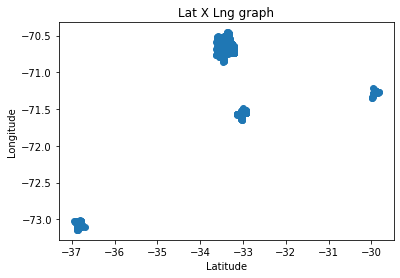

In [65]:
plt.scatter(orders[:]['lat'],orders[:]['lng'])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Lat X Lng graph')

Here we can see that we have 4 group so let's use one K means with 4 clusters to define the values. 

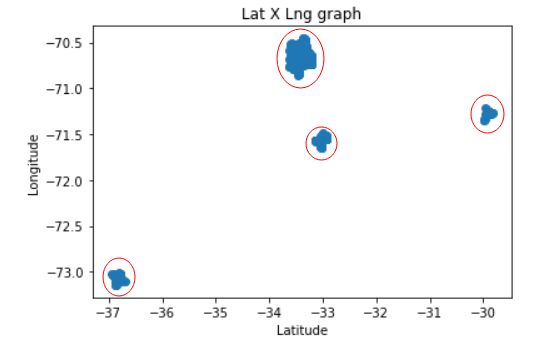

In [66]:
orders[['lat','lng']]

,lat,lng
0,-33.501675,-70.579369
1,-33.440584,-70.556283
2,-32.987022,-71.544842
3,-33.328075,-70.512659
4,-33.403239,-70.564020
...,...,...
9995,-33.417677,-70.508377
9996,-33.432885,-70.646795
9997,-33.424562,-70.582943
9998,-33.413806,-70.598500


In [67]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters= 4,random_state=42)
kmeans.fit(orders[['lat','lng']])
labels = kmeans.labels_
results = pd.DataFrame(data=labels, columns=['cluster'], index=orders.order_id)

In [68]:
results['order_id']=results.index
dfResult = spark.createDataFrame(results)
dfOrdersSpark = spark.createDataFrame(orders)


In [69]:
dfOrderWithCluster = dfOrdersSpark.join(dfResult,("order_id"))

In [70]:
dfOrderWithCluster.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- promised_time: string (nullable = true)
 |-- on_demand: boolean (nullable = true)
 |-- shopper_id: string (nullable = true)
 |-- store_branch_id: string (nullable = true)
 |-- total_minutes: double (nullable = true)
 |-- cluster: long (nullable = true)



In [71]:
order_Df_pandas = dfOrderWithCluster.toPandas()

In [72]:
dfOrderWithCluster.groupBy("cluster")

In [73]:
dfOrderWithCluster

DataFrame[order_id: string, lat: double, lng: double, promised_time: string, on_demand: boolean, shopper_id: string, store_branch_id: string, total_minutes: double, cluster: bigint]

In [75]:
dfOrderWithCluster.groupBy("cluster").agg({"total_minutes":"avg"}).show()

+-------+------------------+
|cluster|avg(total_minutes)|
+-------+------------------+
|      0| 64.81393433342411|
|      1| 67.50159090704807|
|      3| 63.97321400579711|
|      2| 74.39799742592594|
+-------+------------------+



In [76]:
from pyspark.sql import functions as F
dfOrderWithCluster.filter(dfOrderWithCluster.cluster == 1).agg(F.avg('total_minutes')).show()

+------------------+
|avg(total_minutes)|
+------------------+
| 67.50159090704807|
+------------------+



In [77]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, e750294655c2c7c34d83cc3181c09de4 to ac9520e37e420842ce36b65a71b48954
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cluster   10000 non-null  int32 
 1   order_id  10000 non-null  object
dtypes: int32(1), object(1)
memory usage: 195.3+ KB


Text(0.5, 1.0, 'Lat X Lng graph')

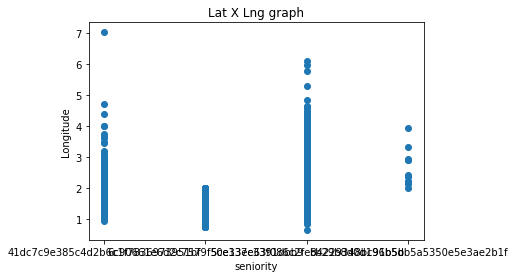

In [78]:
plt.scatter(shoppers[:]['seniority'],shoppers[:]['picking_speed'])
plt.xlabel('seniority')
plt.ylabel('Longitude')
plt.title('Lat X Lng graph')